<a href="https://colab.research.google.com/github/rmkenv/newsletter/blob/main/newsletter5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-3606267395.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  timestamps = pd.date_range('2024-02-01', periods=periods, freq='15T')


Test MAE: 4.08 kW


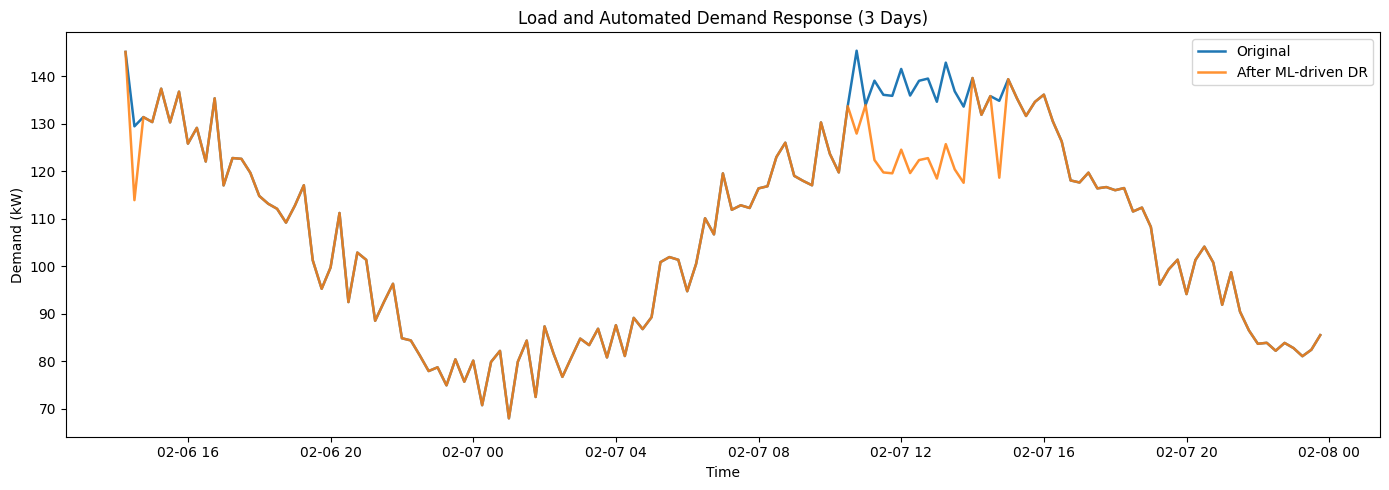

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Generate synthetic 15-minute interval demand data for one week
np.random.seed(42)
periods = 96 * 7  # 7 days, 96 intervals/day
timestamps = pd.date_range('2024-02-01', periods=periods, freq='15T')

hours = timestamps.hour + timestamps.minute/60
temperature = 8 + 10*np.sin((timestamps.dayofyear-80)*2*np.pi/365) + np.random.normal(0, 2, periods)
base_load = 90 + 30*np.sin((hours - 7)*np.pi/12)
weekday_effect = 18 * (timestamps.dayofweek < 5)
random_variation = np.random.normal(0, 5, periods)
demand = base_load + weekday_effect + random_variation + 2.5 * np.maximum(temperature-20, 0)

df = pd.DataFrame({
    'datetime': timestamps,
    'demand': demand,
    'temperature': temperature,
    'hour': hours,
    'dayofweek': timestamps.dayofweek
})

# Prepare machine learning features
features = ['hour', 'dayofweek', 'temperature']
split_idx = int(0.8 * len(df))
X_train, X_test = df[features][:split_idx], df[features][split_idx:]
y_train, y_test = df['demand'][:split_idx], df['demand'][split_idx:]

# Train Random Forest model for demand forecasting
model = RandomForestRegressor(n_estimators=80, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Model performance evaluation
mae = mean_absolute_error(y_test, predictions)
print(f"Test MAE: {mae:.2f} kW")

# Simulate automated demand response: curtail 12% at top 10% of forecasted peaks
df_test = df.iloc[split_idx:].copy()
df_test['predicted'] = predictions
peak_cutoff = df_test['predicted'].quantile(0.90)
df_test['demand_DR'] = df_test['demand']
df_test.loc[df_test['predicted'] > peak_cutoff, 'demand_DR'] *= 0.88

# Visualize three days of results
plt.figure(figsize=(14,5))
plt.plot(df_test['datetime'][:3*96], df_test['demand'][:3*96], label='Original', linewidth=1.8)
plt.plot(df_test['datetime'][:3*96], df_test['demand_DR'][:3*96], label='After ML-driven DR', alpha=0.85, linewidth=1.8)
plt.title('Load and Automated Demand Response (3 Days)')
plt.ylabel("Demand (kW)")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.show()
